<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#define-functions" data-toc-modified-id="define-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>define functions</a></span></li><li><span><a href="#proposed-model" data-toc-modified-id="proposed-model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>proposed model</a></span></li></ul></li><li><span><a href="#Explainable-AI-:-Shap" data-toc-modified-id="Explainable-AI-:-Shap-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Explainable AI : Shap</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PCA</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#3-Principal-components" data-toc-modified-id="3-Principal-components-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>3 Principal components</a></span></li><li><span><a href="#16-Principal-components" data-toc-modified-id="16-Principal-components-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>16 Principal components</a></span></li><li><span><a href="#4-Principal-components" data-toc-modified-id="4-Principal-components-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>4 Principal components</a></span></li></ul></li></ul></li><li><span><a href="#LSTM-without-feature-clustering" data-toc-modified-id="LSTM-without-feature-clustering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LSTM without feature clustering</a></span></li><li><span><a href="#comparing-between-the-PCA-with-4PC+LSTM(1)-and-the-7-clusters-et-LSTM(2)-with-without-feature-clustering" data-toc-modified-id="comparing-between-the-PCA-with-4PC+LSTM(1)-and-the-7-clusters-et-LSTM(2)-with-without-feature-clustering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>comparing between the PCA with 4PC+LSTM(1) and the 7 clusters et LSTM(2) with without feature clustering</a></span></li></ul></div>

## Data

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import keras
import math
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GroupKFold ,GroupShuffleSplit
from sklearn import preprocessing
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from scipy import optimize
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### define functions

In [9]:
# get the FD004 data
def get_data():
    dir_path = 'C:/Users/aalah/0_Stage_CESI/turbofan_failure-master/data/' 
    dependent_var = ['RUL']
    index_names = ['Unit', 'Cycle']
    setting_names = ['Altitude', 'Mach', 'TRA']
    sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
    col_names = index_names + setting_names + sensor_names
    
    df_train = pd.read_csv(dir_path+'train_FD004.txt',delim_whitespace=True,names=col_names)

    rul_train = pd.DataFrame(df_train.groupby('Unit')['Cycle'].max()).reset_index()
    rul_train.columns = ['Unit', 'max']
    df_train = df_train.merge(rul_train, on=['Unit'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv(dir_path+'test_FD004.txt', delim_whitespace=True, names=col_names)
    
    y_test = pd.read_csv(dir_path+'RUL_FD004.txt', delim_whitespace=True,names=["RUL"])
    #y_true["Unit"] = y_true.index + 1
    return df_train, df_test, y_test


##--------------- data preprocessing --------------------------------##

#add operational condition to then normalize the data based on these operational conditions
def add_operational_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['Altitude'] = df_op_cond['Altitude'].round()
    df_op_cond['Mach'] = df_op_cond['Mach'].round(decimals=2)
    df_op_cond['TRA'] = df_op_cond['TRA'].round()
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['Altitude'].astype(str) + '_' + \
                        df_op_cond['Mach'].astype(str) + '_' + \
                        df_op_cond['TRA'].astype(str)
    
    return df_op_cond

# Normalize the data based on the operational condition
def condition_scaler(df_train, df_test, sensor_names): 
    #Apply operating condition specific scaling

    scaler = MinMaxScaler(feature_range = (0, 1))
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test


# denoise the signal using the exponential signal wih using the variable alpha
def exponential_smoothing(df, sensors, n_samples, alpha):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    df[sensors] = df.groupby('Unit')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('Unit')['Unit'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df


#to plot each sensors with respect to the RUL
def plot_signal(df, signal_name, unit=None): #Visualisation
    plt.figure(figsize=(13,5))
    if unit:
        plt.plot('RUL', signal_name, 
                data=df[df['Unit']==unit])
    else:
        for i in train['Unit'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name, 
                         data=df[df['Unit']==i])
    plt.xlim(350, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 375, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    #plt.savefig(signal_name+'.jpeg')
    plt.show()



#generate train data sequences of 3D dimension for the LSTM's input    
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

def gen_data_sequences_train(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['Unit'].unique()
        
    data_gen = (list(gen_train_data(df[df['Unit']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

#generate train RULs (labels) sequences of 3D dimension for the LSTM's input
def gen_ruls(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_rul_sequences_train(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['Unit'].unique()
        
    label_gen = [gen_ruls(df[df['Unit']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array


#generate test data sequence of 3D dimension for the LSTM's input
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :] 
        

        
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def new_column (df, column):
    #df = df.sort_values(by=column, ascending=False)
    df[column] = range(1, len(df) + 1)
    return df

#----------------------------Prepare data for searching exponential smoothing's alpha (Grid Search)-------------------#

def prep_data(X_train, X_test, chosen_sensors, alpha, rul):

    X_train_interim, X_test_interim = condition_scaler(X_train, X_test, chosen_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, chosen_sensors, 0, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, chosen_sensors, 0, alpha)
    
    X_train_interim['RUL'].clip(upper=rul, inplace=True)
    
    return X_train_interim, X_test_interim

def rul_piecewise_fct(X_train, rul):
    
    X_train['RUL'].clip(upper=rul, inplace=True)
    
    return X_train

#------------------------------------------LSTM model used ------------------------------#

#def create_lstm_model(input_shape, nodes_per_layer, dropout, learning_rate_):
def create_lstm_model(input_shape, dropout, learning_rate_):
    model = Sequential()
    #model.add(LSTM(units=nodes_per_layer, activation='tanh',input_shape=(sequence_length, 7)))
    #model.add(Dense(units=nodes_per_layer, activation='relu'))
    model.add(LSTM(units=128, activation='tanh',input_shape=(sequence_length, len(remaining_sensors_7))))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse',metrics=['mse'], optimizer=tf.keras.optimizers.Adam(lr=learning_rate_))
    return model       
        
#----------------------------------Model evaluation metrics -------------------------# 

def compute_MAPE(y_true, y_hat):
    mape = np.mean(np.abs((y_true - y_hat)/y_true))*100
    return mape


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

#the score defined in the paper
def compute_s_score(rul_true, rul_pred):
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

#evaluate the model with R² and RMSE
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [10]:
# get data

train, test, y_test = get_data()
train = train.drop(['T20','P20','Nf_dmd','PCNfR_dmd','farB'],axis=1)
test = test.drop(['T20','P20','Nf_dmd','PCNfR_dmd','farB'],axis=1)
train.shape, test.shape, y_test.shape

((61249, 22), (41214, 21), (248, 1))

In [11]:
#The chosen sensors signify the remaining 16 sensors after normalization
chosen_sensors = ['T24', 'T30', 'T50', 'P15', 'P30','Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31','W32']

#adding operational condition
X_train_interm = add_operational_condition(train)
X_test_interm = add_operational_condition(test)
#normalizing based on these operational condition
X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_interm, X_test_interm, chosen_sensors)

#drop the operational condition variables as they were only helpful for the scaling
data_train = X_train_condition_scaled.drop(['Cycle','Altitude', 'Mach', 'TRA','op_cond'],axis=1)
data_test = X_test_condition_scaled.drop(['Cycle','Altitude', 'Mach', 'TRA','op_cond'],axis=1)



In [12]:
# smooth the signal 
train_smooth = exponential_smoothing(data_train,chosen_sensors,0,0.3)
test_smooth = exponential_smoothing(data_test,chosen_sensors,0,0.3)
df_train_unit = train_smooth.Unit
df_test_unit = test_smooth.Unit
df_train_RUL = train_smooth.RUL
train_smooth['RUL'].clip(upper=130, inplace=True)
Xtrain = train_smooth.drop(['RUL','Unit'],axis=1)
Xtest = test_smooth.drop(['Unit'],axis=1)

In [13]:
#get output file from RStudio after performining ClustOfVar

df7 = pd.read_csv('C:/Users/aalah/Downloads/d7.txt',sep=',',names=['cluster1','cluster2','cluster3','cluster4','cluster5','cluster6','cluster7'
])
df_train_rul = train['RUL']
df_train_unit = train['Unit']
df_test_unit = test['Unit']

#As the file has train and test merged together, we will split them into train and test

cluster7_train = df7[ :61249 ].reset_index()
cluster7_train = cluster7_train.drop('index',axis=1)
cluster7_test = df7[ 61249 : ].reset_index()
cluster7_test = cluster7_test.drop('index',axis=1)


#We add Unit and RUL to these newly created datasets

mid7_train = pd.concat([cluster7_train, df_train_rul], axis=1, join="inner")
train_7 = pd.concat([df_train_unit,mid7_train], axis=1, join="inner")
test_7 = pd.concat([df_test_unit,cluster7_test], axis=1, join="inner")


In [14]:
sequence_length = 30 #TW was found using grid-search


train_7['RUL'].clip(upper=130, inplace=True) #Rectified RUL was found using grid-search

remaining_sensors_7 = ['cluster1','cluster2','cluster3','cluster4','cluster5','cluster6','cluster7']


In [15]:
train_7.drop(['Unit'],axis=1).corr()

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,RUL
cluster1,1.000000,-0.508032,-0.278424,-0.564850,-0.537588,-0.370279,0.204259,0.798214
cluster2,-0.508032,1.000000,-0.138139,0.190258,0.091520,-0.024214,-0.430536,-0.129123
cluster3,-0.278424,-0.138139,1.000000,0.532406,0.634178,0.862535,0.850918,-0.354672
cluster4,-0.564850,0.190258,0.532406,1.000000,0.799138,0.596643,0.307028,-0.563758
cluster5,-0.537588,0.091520,0.634178,0.799138,1.000000,0.616566,0.380294,-0.594117
cluster6,-0.370279,-0.024214,0.862535,0.596643,0.616566,1.000000,0.706224,-0.396438
cluster7,0.204259,-0.430536,0.850918,0.307028,0.380294,0.706224,1.000000,0.018556
RUL,0.798214,-0.129123,-0.354672,-0.563758,-0.594117,-0.396438,0.018556,1.000000


Text(0.5, 1.0, '[FD004: 7 clusters (Train)] Correlation Heatmap')

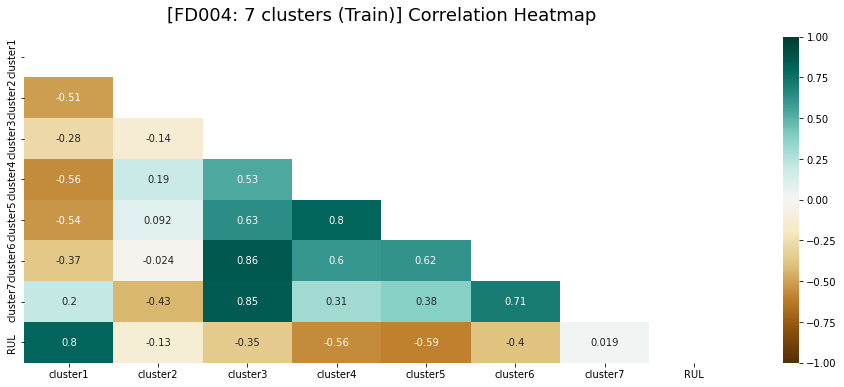

In [16]:
plt.figure(figsize=(16, 6))# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(train_7.drop(['Unit'],axis=1).corr(), dtype=np.bool))
heatmap = sns.heatmap(train_7.drop(['Unit'],axis=1).corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('[FD004: 7 clusters (Train)] Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

In [17]:
g = test_7.groupby('Unit')
dataframe = pd.concat([(pd.concat([g.tail(1)]).sort_values('Unit').reset_index(drop=True)),y_test], axis=1, join="inner")

Text(0.5, 1.0, '[FD004: 7 clusters (Test)] Correlation Heatmap')

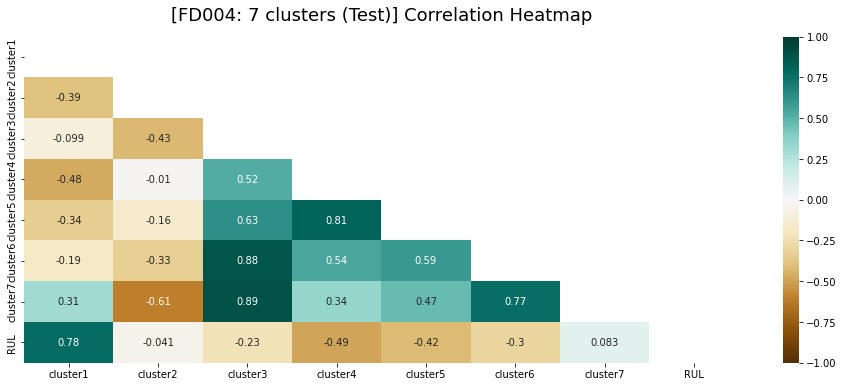

In [18]:
plt.figure(figsize=(16, 6))# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(dataframe.drop(['Unit'],axis=1).corr(), dtype=np.bool))
heatmap = sns.heatmap(dataframe.drop(['Unit'],axis=1).corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('[FD004: 7 clusters (Test)] Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

### proposed model

In [19]:
# load our model with 1 LSTM layer

loaded_model_lstm_7 = tf.keras.models.load_model('C:/Users/aalah/Downloads/model_FD004_clusters_130_best')
loaded_model_lstm_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               69632     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 86,273
Trainable params: 86,273
Non-trainable params: 0
_________________________________________________________________


In [20]:
# create sequences train, test 
train_array_7 = gen_data_sequences_train(train_7, sequence_length,remaining_sensors_7)
label_array_7 = gen_rul_sequences_train(train_7, sequence_length, ['RUL'])

test_gen_7 = (list(gen_test_data(test_7[test_7['Unit']==unit_nr], sequence_length,remaining_sensors_7, -99.))
           for unit_nr in test_7['Unit'].unique())
test_array_7 = np.concatenate(list(test_gen_7)).astype(np.float32)

y_true_clipped = y_test.copy()

y_true_clipped.clip(upper=130,inplace=True)

In [21]:
# predict and evaluate
print('(FD004) For 7 clusters (Unclipped true RUL): ')
y_hat_train = loaded_model_lstm_7.predict(train_array_7)
evaluate(label_array_7, y_hat_train, 'train')

y_hat_test = loaded_model_lstm_7.predict(test_array_7)
evaluate(y_test, y_hat_test)

print('  ')
print('(FD004) For 7 clusters (Clipped true RUL): ')
y_hat_test = loaded_model_lstm_7.predict(test_array_7)
evaluate(y_true_clipped, y_hat_test)

(FD004) For 7 clusters (Unclipped true RUL): 
train set RMSE:15.433294296264648, R2:0.8730758709070203
test set RMSE:25.451214849685496, R2:0.7821061812959538
  
(FD004) For 7 clusters (Clipped true RUL): 
test set RMSE:16.140314014674942, R2:0.8678543634792815


In [22]:
print("(FD004-Test) S-score For 7 clusters (Unclipped true RUL) : ",compute_s_score(y_test, y_hat_test))
print('  ')
print("(FD004-Test) S-score For 7 clusters (Clipped true RUL) : ",compute_s_score(y_true_clipped, y_hat_test))
print('  ')
print("(FD004-Test) MAPE For 7 clusters (Unclipped true RUL): ",compute_MAPE(y_test, y_hat_test))
print('  ')
print("(FD004-Test) MAPE For 7 clusters (Clipped true RUL) : ",compute_MAPE(y_true_clipped, y_hat_test))

(FD004-Test) S-score For 7 clusters (Unclipped true RUL) :  4144.575388129244
  
(FD004-Test) S-score For 7 clusters (Clipped true RUL) :  1299.1969731549616
  
(FD004-Test) MAPE For 7 clusters (Unclipped true RUL):  RUL    27.451503
dtype: float64
  
(FD004-Test) MAPE For 7 clusters (Clipped true RUL) :  RUL    23.487267
dtype: float64


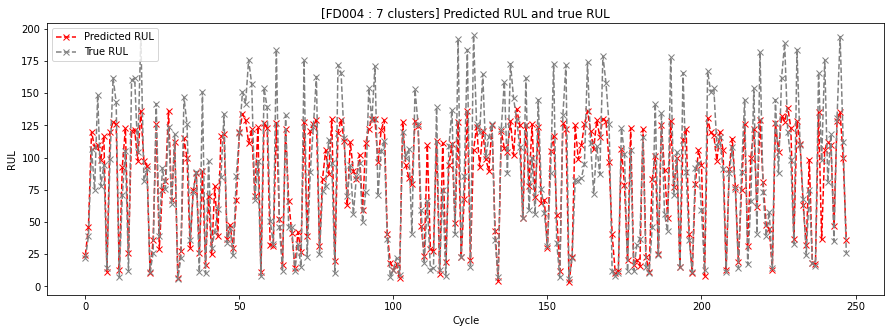

In [23]:
#for test dataset
plt.figure(figsize=(15,5))
plt.plot(y_hat_test, color='red', label='Predicted RUL',marker='x',linestyle ='--')
plt.plot(y_test, color='gray', label='True RUL',marker='x',linestyle ='--')
plt.ylabel("RUL")
plt.xlabel("Cycle")
plt.legend(loc='upper left')
plt.title('[FD004 : 7 clusters] Predicted RUL and true RUL')
plt.show()

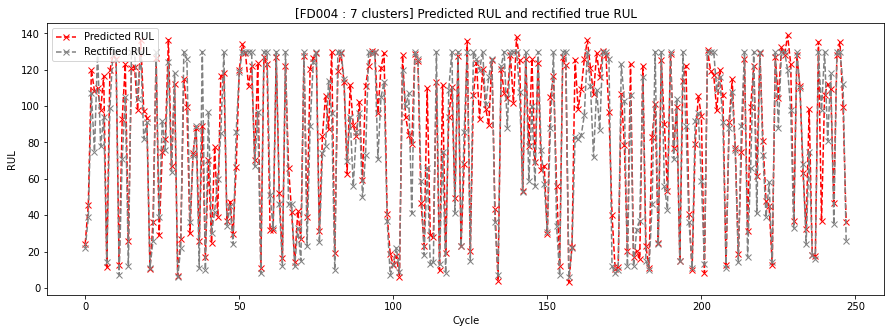

In [24]:
#for test dataset
plt.figure(figsize=(15,5))
plt.plot(y_hat_test, color='red', label='Predicted RUL',marker='x',linestyle ='--')
plt.plot(y_true_clipped, color='gray', label='Rectified RUL',marker='x',linestyle ='--')
plt.ylabel("RUL")
plt.xlabel("Cycle")
plt.legend(loc='upper left')
plt.title('[FD004 : 7 clusters] Predicted RUL and rectified true RUL')
plt.show()

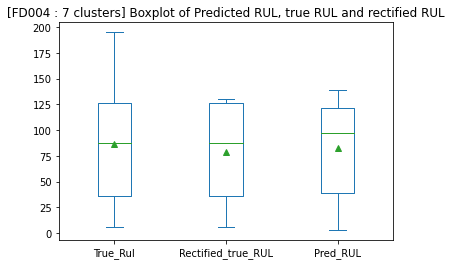

In [25]:
#test 
flat_y_hat_7 = np.ravel(y_hat_test)
flat_y_true = np.ravel(y_test)
flat_y_true_clipped = np.ravel(y_true_clipped)

DF_test = pd.DataFrame({'True_Rul': flat_y_true,'Rectified_true_RUL': flat_y_true_clipped, 'Pred_RUL': flat_y_hat_7})

ax = DF_test[['True_Rul','Rectified_true_RUL', 'Pred_RUL']].plot(kind='box', title='[FD004 : 7 clusters] Boxplot of Predicted RUL, true RUL and rectified RUL', showmeans=True)

plt.show()

In [26]:
columns = ['s_score_7_clusters', 's_score_7_clusters_clip', 'd_7_clusters_clip', 'd_7_clusters', 'RMSE_7_clusters', 'RMSE_7_clusters_clip', 'Cor_7clust', 'Cor_7clust_clip']

for col in columns:
    DF_test = new_column(DF_test, col)

In [27]:
for i in range(len(DF_test.True_Rul)):
    DF_test['s_score_7_clusters'][i]=compute_s_score(DF_test.True_Rul[i],DF_test.Pred_RUL[i])
    DF_test['d_7_clusters'][i]= DF_test.Pred_RUL[i] - DF_test.True_Rul[i]
    DF_test['RMSE_7_clusters'][i]= root_mean_squared_error(DF_test.True_Rul[i],DF_test.Pred_RUL[i])
    DF_test['s_score_7_clusters_clip'][i]=compute_s_score(DF_test.Rectified_true_RUL[i],DF_test.Pred_RUL[i])
    DF_test['d_7_clusters_clip'][i]= DF_test.Pred_RUL[i] - DF_test.Rectified_true_RUL[i]
    DF_test['RMSE_7_clusters_clip'][i]= root_mean_squared_error(DF_test.Rectified_true_RUL[i],DF_test.Pred_RUL[i])

In [28]:
DF_test['Cor_7clust'] = np.where(DF_test.d_7_clusters < -13, 'FP', np.where(DF_test.d_7_clusters > 10, 'FN', '1'))
DF_test['Cor_7clust_clip'] = np.where(DF_test.d_7_clusters_clip < -13, 'FP', np.where(DF_test.d_7_clusters_clip > 10, 'FN', '1'))

In [29]:
DF_test.describe()

,True_Rul,Rectified_true_RUL,Pred_RUL,s_score_7_clusters,s_score_7_clusters_clip,d_7_clusters_clip,d_7_clusters,RMSE_7_clusters,RMSE_7_clusters_clip
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,86.552419,79.125000,82.191444,16.711998,5.238697,3.066446,-4.360974,19.032939,11.896870
std,54.634054,44.490054,42.728584,65.147933,12.233847,15.878390,25.125520,16.931257,10.929588
min,6.000000,6.000000,3.019173,0.001061,0.001061,-61.393436,-89.137596,0.010605,0.010605
25%,36.000000,36.000000,39.040292,0.605859,0.305527,-4.650210,-18.397741,5.237692,3.191210
50%,88.000000,88.000000,97.254143,2.687879,1.123596,1.516660,0.860460,15.076660,8.123750
75%,126.750000,126.750000,121.706453,11.555973,4.066649,11.183425,11.183425,29.598778,17.814741
max,195.000000,130.000000,138.929611,949.262407,111.457124,43.813622,43.813622,89.137596,61.393436


In [30]:
DF_test.groupby(['Cor_7clust']).size()

Cor_7clust
1     107
FN     67
FP     74
dtype: int64

In [31]:
DF_test.groupby(['Cor_7clust_clip']).size()

Cor_7clust_clip
1     149
FN     67
FP     32
dtype: int64

Text(0.5, 1.0, '[FD004: 7 clusters] $h_i$ for Predicted RUL and Rectified True RUL')

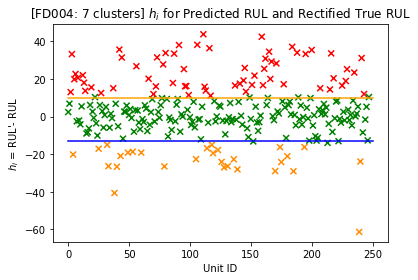

In [32]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([0,50,100,150,200,250])
y = np.full(6, -13)
y2 = np.full(6, 10)

# vectorized conditionals for color selection
colors = np.where(DF_test.d_7_clusters_clip > 11, 'red', np.where(DF_test.d_7_clusters_clip < -14, 'darkorange', 'green'))

# plot all data at once using the plot function
plt.plot(x, y, color='blue')
plt.plot(x, y2, color='orange')
plt.scatter(DF_test.index, DF_test.d_7_clusters_clip, marker="x", c=colors)

plt.xlabel('Unit ID')
plt.ylabel('$h_i$ = RUL\'- RUL')
plt.title('[FD004: 7 clusters] $h_i$ for Predicted RUL and Rectified True RUL')


In [33]:
dataframe_test = DF_test.sort_values('True_Rul',ascending=True).reset_index()

In [34]:
FN_mask = (dataframe_test.d_7_clusters_clip > 9) & (dataframe_test.d_7_clusters_clip <= 10)
FN = dataframe_test.loc[FN_mask, 'Pred_RUL'].tolist()
FN_index = dataframe_test.loc[FN_mask, 'index'].tolist()

FP_mask = (dataframe_test.d_7_clusters_clip > -14) & (dataframe_test.d_7_clusters_clip <= -12)
FP = dataframe_test.loc[FP_mask, 'Pred_RUL'].tolist()
FP_index = dataframe_test.loc[FP_mask, 'index'].tolist()

Text(0.5, 1.0, '[FD004: 7 clusters] $h_i$ for Predicted RUL and True RUL')

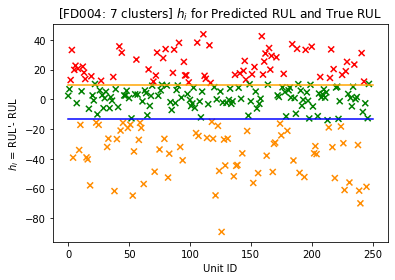

In [35]:
x = np.array([0,50,100,150,200,250])
y = np.full(6, -13)
y2 = np.full(6, 10)

# vectorized conditionals for color selection
colors = np.where(DF_test.d_7_clusters > 11, 'red', np.where(DF_test.d_7_clusters < -14, 'darkorange', 'green'))

# plot all data at once using the plot function
plt.plot(x, y, color='blue')
plt.plot(x, y2, color='orange')
plt.scatter(DF_test.index, DF_test.d_7_clusters, marker="x", c=colors)

plt.xlabel('Unit ID')
plt.ylabel('$h_i$ = RUL\'- RUL')
plt.title('[FD004: 7 clusters] $h_i$ for Predicted RUL and True RUL')


<AxesSubplot:xlabel='RMSE_7_clusters', ylabel='Density'>

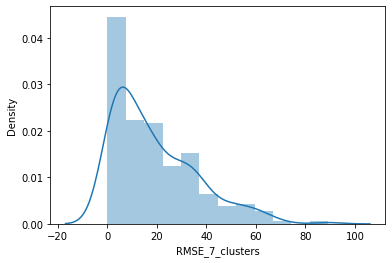

In [36]:
sns.distplot(DF_test.RMSE_7_clusters)

<AxesSubplot:title={'center':'[FD004: 7 clusters] Boxplot of RMSE rectified true RUL'}>

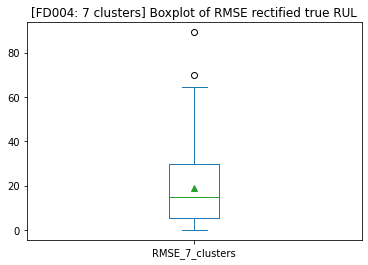

In [37]:
DF_test.RMSE_7_clusters.plot(kind='box', title='[FD004: 7 clusters] Boxplot of RMSE rectified true RUL', showmeans=True)

In [ ]:
for unit in train_7['Unit'].unique():
    engine1 = train_7[train_7['Unit']==unit]
    
    
    engine_array1 = gen_data_sequences_train(engine1, sequence_length,remaining_sensors_7)
    engine_label_array1 = gen_rul_sequences_train(engine1, sequence_length, ['RUL'])
    
    y_hat_engine1 = loaded_model_lstm_7.predict(engine_array1)
    error = y_hat_engine1 - engine_label_array1
    # for one engine from the train dataset
    plt.figure(figsize=(10,5))
    x = list(np.arange(0,len(engine1)+1,50))
    y = [0] * len(x)
    y1 = [-13] * len(x)
    y2 = [10] * len(x)
    plt.plot(x, y2 , color='indigo', label='FN limit') 
    plt.plot(x, y1 , color='green', label='FP limit') 
    #plt.plot(y_hat_engine16, color='red', label='Predicted RUL (16 PC)')
    plt.plot(engine_label_array1, color='blue', label='True RUL')
    plt.plot(y_hat_engine1, color='red', label='Predicted RUL')
    plt.plot(error, color='gray',linestyle ='--', label='$d_i$ = RUL\'-RUL')
    plt.ylabel("RUL")
    plt.xlabel("Cycle")
    plt.legend(loc='upper right')
    plt.title('[FD004 : 7 clusters]  Engine %d' %unit)
    #plt.savefig('C:/Users/aalah/Downloads/Final_results/7_Clust_error/Unit_%d.jpeg'%unit)
    #plt.show()


In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
ax = data_rmse_tw.plot.bar(x='TW',y='RMSE')

#plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

ax.bar_label(ax.containers[0])
plt.title('Time window size performance on the LSTM model')
plt.xlabel('Time window size')
plt.ylabel('RMSE')
plt.show()

## Explainable AI : Shap

In [52]:
!pip install shap

In [104]:
import shap   
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
  
tf.compat.v1.disable_v2_behavior()

print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)
# print the JS visualization code to the notebook
shap.initjs()


explainer = shap.DeepExplainer(loaded_model_lstm_7,train_array_7)
shap_values = explainer.shap_values(test_array_7)

SHAP version is: 0.41.0
Tensorflow version is: 2.6.0


In [ ]:
#! pip3 install tensorflow-gpu --user

In [ ]:
with open("explainer.sav", "wb") as f:
     explainer.save(f)

In [ ]:
shap_values = explainer.shap_values(test_array_7)

In [98]:
with open('shap_values.txt', 'w') as f:
    for value in shap_values:
        f.write(f"{value}\n")

In [107]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], remaining_sensors_7)

In [82]:
print("Base Value : ", explainer.expected_value)

Base Value :  [101.3882]


In [ ]:
explainer.expected_value

In [103]:
len(shap_values)

1

In [ ]:
test_array_7.shape

In [106]:
shap_values[0][0].shape

(30, 7)

In [ ]:
i = 8
pred_i = model.predict(test_array_7[i:i+1])
sum_shap_i = shap_values[0][i].sum() + explainer.expected_value[0]

pred_i, sum_shap_i

In [106]:
# Plot SHAP for ONLY one observation i
i = 10
shap.initjs()

test_array_7_df = pd.DataFrame(data=test_array_7[i], columns = remaining_sensors_7)
shap.force_plot(explainer.expected_value[0], shap_values[0][i], test_array_7_df)
## Problem:  Can not take into account many observations at the same time.
### The pic below explain for only 1 observation of 30 time steps, each time step has 7 clusters.

In [108]:
################# Plot AVERAGE shap values for ALL observations  #####################
## Consider ABSOLUTE of SHAP values ##
shap_average_abs_value = np.abs(shap_values[0]).mean(axis=0)

x_average_value = pd.DataFrame(data=test_array_7.mean(axis=0), columns = remaining_sensors_7)
shap.force_plot(0, shap_average_abs_value, x_average_value)

In [109]:
# plot time step 7th for average shap
i = 0
shap.force_plot(0, shap_average_abs_value[i], x_average_value.iloc[i,:])

In [110]:
################# Plot AVERAGE shap values for ALL observations  #####################
## Consider average (+ is different from -)
shap_average_value = shap_values[0].mean(axis=0)

x_average_value = pd.DataFrame(data=test_array_7.mean(axis=0), columns = remaining_sensors_7)
shap.force_plot(explainer.expected_value[0], shap_average_value, x_average_value)

In [107]:
print(remaining_sensors_7)
print(len(remaining_sensors_7))

['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7']
7


In [111]:
i=0
j=0
test_array_7_df = pd.DataFrame(data=test_array_7[i][j].reshape(1,7), columns = remaining_sensors_7)
shap.force_plot(explainer.expected_value[0], shap_values[0][i][j], test_array_7_df)

In [115]:
shap_values_2D = shap_values[0].reshape(-1,7)
X_test_2D = test_array_7.reshape(-1,7)


shap_values_2D.shape,X_test_2D.shape
## 248x30=7440

((7440, 7), (7440, 7))

In [116]:
x_test_2d = pd.DataFrame(data=X_test_2D, columns = remaining_sensors_7)

In [117]:
x_test_2d.corr()

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
cluster1,1.000000,0.964570,0.967999,0.959317,0.962277,0.971246,0.976183
cluster2,0.964570,1.000000,0.978986,0.984760,0.983130,0.986916,0.966184
cluster3,0.967999,0.978986,1.000000,0.989598,0.992867,0.996964,0.995590
cluster4,0.959317,0.984760,0.989598,1.000000,0.995196,0.993043,0.981600
cluster5,0.962277,0.983130,0.992867,0.995196,1.000000,0.993847,0.985302
cluster6,0.971246,0.986916,0.996964,0.993043,0.993847,1.000000,0.991172
cluster7,0.976183,0.966184,0.995590,0.981600,0.985302,0.991172,1.000000


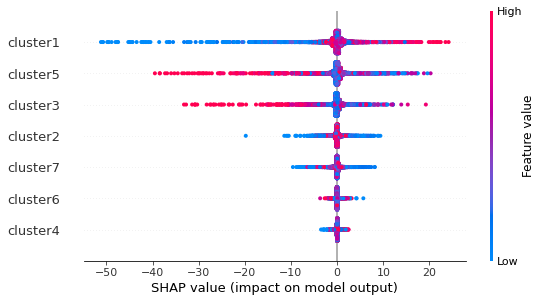

In [118]:
shap.summary_plot(shap_values_2D, x_test_2d)

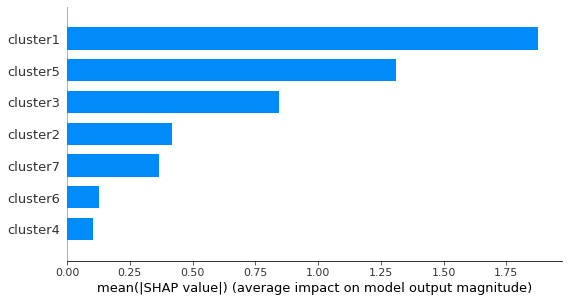

In [119]:
shap.summary_plot(shap_values_2D, x_test_2d, plot_type="bar")

## PCA

In [104]:
#The chosen sensors signify the remaining 16 sensors after normalization
chosen_sensors = ['T24', 'T30', 'T50', 'P15', 'P30','Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31','W32']

#adding operational condition
X_train_interm = add_operational_condition(train)
X_test_interm = add_operational_condition(test)
#normalizing based on these operational condition
X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_interm, X_test_interm, chosen_sensors)

#drop the operational condition variables as they were only helpful for the scaling
data_train = X_train_condition_scaled.drop(['Cycle','Altitude', 'Mach', 'TRA','op_cond'],axis=1)
data_test = X_test_condition_scaled.drop(['Cycle','Altitude', 'Mach', 'TRA','op_cond'],axis=1)

#perform exponential smoothing on the data
train_smooth = exponential_smoothing(data_train,chosen_sensors,0,0.3) #here alpha=0.3, was found when performing GridSearch
test_smooth = exponential_smoothing(data_test,chosen_sensors,0,0.3)

In [105]:
# smooth the signal 
train_smooth['RUL'].clip(upper=130, inplace=True)
Xtrain = train_smooth.drop(['RUL','Unit'],axis=1)
Xtest = test_smooth.drop(['Unit'],axis=1)
#y_test['RUL'].clip(upper=130, inplace=True)

In [106]:
pca_16 = PCA(n_components=16)
pca_16.fit(Xtrain)

pca_4 = PCA(n_components=4)
pca_4.fit(Xtrain)

pca_3 = PCA(n_components=3)
pca_3.fit(Xtrain)

In [109]:
columns_16 = ['pca_%i' % i for i in range(16)]
columns_4 = ['pca_%i' % i for i in range(4)]
columns_3 = ['pca_%i' % i for i in range(3)]

df_pca_16 = pd.DataFrame(pca_16.transform(Xtrain), columns=columns_16, index=Xtrain.index)
df_pca_4 = pd.DataFrame(pca_4.transform(Xtrain), columns=columns_4, index=Xtrain.index)
df_pca_3 = pd.DataFrame(pca_3.transform(Xtrain), columns=columns_3, index=Xtrain.index)
#df_pca.head()

In [110]:
train_pca_16 = pca_16.transform(Xtrain)
test_pca_16 = pca_16.transform(Xtest)

train_pca_4 = pca_4.transform(Xtrain)
test_pca_4 = pca_4.transform(Xtest)

train_pca_3 = pca_3.transform(Xtrain)
test_pca_3 = pca_3.transform(Xtest)

In [111]:
columns_16=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16']
columns_4=['PC1','PC2','PC3','PC4']
columns_3=['PC1','PC2','PC3']
PCA_test_16 = pd.DataFrame(test_pca_16,columns=columns_16)
df_PCA_test_16 = pd.concat([df_test_unit,PCA_test_16], axis=1, join="inner")

PCA_test_4 = pd.DataFrame(test_pca_4,columns=columns_4)
df_PCA_test_4 = pd.concat([df_test_unit,PCA_test_4], axis=1, join="inner")

PCA_test_3 = pd.DataFrame(test_pca_3,columns=columns_3)
df_PCA_test_3 = pd.concat([df_test_unit,PCA_test_3], axis=1, join="inner")

In [112]:
# 16 components
PCA_train_16 = pd.DataFrame(train_pca_16,columns=columns_16)
mid_PCA_train_16 = pd.concat([df_train_unit,PCA_train_16], axis=1, join="inner")
df_PCA_train_16 = pd.concat([mid_PCA_train_16 , df_train_RUL], axis=1, join="inner")

# 4 components
PCA_train_4 = pd.DataFrame(train_pca_4,columns=columns_4)
mid_PCA_train_4 = pd.concat([df_train_unit,PCA_train_4], axis=1, join="inner")
df_PCA_train_4 = pd.concat([mid_PCA_train_4 , df_train_RUL], axis=1, join="inner")

# 3 components
PCA_train_3 = pd.DataFrame(train_pca_3,columns=columns_3)
mid_PCA_train_3 = pd.concat([df_train_unit,PCA_train_3], axis=1, join="inner")
df_PCA_train_3 = pd.concat([mid_PCA_train_3 , df_train_RUL], axis=1, join="inner")

In [113]:
model_3 = tf.keras.models.load_model('C:/Users/aalah/Downloads/model_3PC')
model_4 = tf.keras.models.load_model('C:/Users/aalah/Downloads/model_4PC')
model_16 = tf.keras.models.load_model('C:/Users/aalah/Downloads/my_model_16_PC')

In [162]:
sequence_length = 30
  
# create sequences train, test 
train_array_16 = gen_data_wrapper(df_PCA_train_16, sequence_length,columns_16)
label_array_16 = gen_label_wrapper(df_PCA_train_16, sequence_length, ['RUL'])

test_gen_16 = (list(gen_test_data(df_PCA_test_16[df_PCA_test_16['Unit']==unit_nr], sequence_length,columns_16, -99.))
           for unit_nr in df_PCA_test_16['Unit'].unique())
test_array_16 = np.concatenate(list(test_gen_16)).astype(np.float32)


# create sequences train, test 
train_array_4 = gen_data_wrapper(df_PCA_train_4, sequence_length,columns_4)
label_array_4 = gen_label_wrapper(df_PCA_train_4, sequence_length, ['RUL'])

test_gen_4 = (list(gen_test_data(df_PCA_test_4[df_PCA_test_4['Unit']==unit_nr], sequence_length,columns_4, -99.))
           for unit_nr in df_PCA_test_4['Unit'].unique())
test_array_4 = np.concatenate(list(test_gen_4)).astype(np.float32)


# create sequences train, test 
train_array_3 = gen_data_wrapper(df_PCA_train_3, sequence_length,columns_3)
label_array_3 = gen_label_wrapper(df_PCA_train_3, sequence_length, ['RUL'])

test_gen_3 = (list(gen_test_data(df_PCA_test_3[df_PCA_test_3['Unit']==unit_nr], sequence_length,columns_3, -99.))
           for unit_nr in df_PCA_test_3['Unit'].unique())
test_array_3 = np.concatenate(list(test_gen_3)).astype(np.float32)

#### 3 Principal components

In [127]:
# predict and evaluate 3 PC
print("Model evaluationg for FD004 using 3 PC [Unclipped True RUL]")
y_hat_train_3 = model_3.predict(train_array_3)
evaluate(label_array_3, y_hat_train_3, 'train')

y_hat_test_3 = model_3.predict(test_array_3)
evaluate(y_test, y_hat_test_3)
print(' ')
print("Model evaluationg for FD004 using 3 PC [Clipped True RUL]")
y_hat_test_3 = model_3.predict(test_array_3)
evaluate(y_test['RUL'].clip(upper=150), y_hat_test_3)
print(' ')
print("S-score for test (using 3 PC) [Unclipped True RUL] : ",compute_s_score(y_test, y_hat_test_3))
print(' ')
print("S-score for test (using 3 PC) [Clipped True RUL] : ",compute_s_score(y_true_clipped, y_hat_test_3))
print(' ')
print('MAPE For Test (using 3 PC) [Unclipped True RUL]: ', compute_MAPE(y_test, y_hat_test_3))
print(' ')
print('MAPE For Test (using 3 PC) [Clipped True RUL] : ', compute_MAPE(y_true_clipped, y_hat_test_3))

Model evaluationg for FD004 using 3 PC [Unclipped True RUL]
train set RMSE:19.96845817565918, R2:0.8424350967985981
test set RMSE:24.396329168096177, R2:0.7997941124419221
 
Model evaluationg for FD004 using 3 PC [Clipped True RUL]
test set RMSE:20.745007535008813, R2:0.8245758590774918
 
S-score for test (using 3 PC) [Unclipped True RUL] :  3962.700518558349
 
S-score for test (using 3 PC) [Clipped True RUL] :  2702.2122068608
 
MAPE For Test (using 3 PC) [Unclipped True RUL]:  RUL    27.65305
dtype: float64
 
MAPE For Test (using 3 PC) [Clipped True RUL] :  RUL    26.153917
dtype: float64


#### 16 Principal components

In [145]:
# predict and evaluate 16 PC
print("Model evaluation for FD004 using 16 PC [Unclipped True RUL] ")
y_hat_train_16 = model_16.predict(train_array_16)
evaluate(label_array_16, y_hat_train_16, 'train')

y_hat_test_16 = model_16.predict(test_array_16)
evaluate(y_test, y_hat_test_16)
print(' ')
print("Model evaluation for FD004 using 16 PC [Clipped True RUL]")

y_hat_test_16 = model_16.predict(test_array_16)
evaluate(y_test['RUL'].clip(upper=150), y_hat_test_16)
print(' ')
print("S-score for test (using 16 PC) [Unclipped True RUL]: ",compute_s_score(y_test, y_hat_test_16))
print(' ')
print("S-score for test (using 16 PC) [Clipped True RUL]: ",compute_s_score(y_true_clipped, y_hat_test_16))
print(' ')
print('MAPE For Test (using 16 PC) [Unclipped True RUL]: ', compute_MAPE(y_test, y_hat_test_16))
print(' ')
print('MAPE For Test (using 16 PC) [Clipped True RUL] : ', compute_MAPE(y_true_clipped, y_hat_test_16))
print(' ')

Model evaluation for FD004 using 16 PC [Unclipped True RUL] 
train set RMSE:21.736318588256836, R2:0.8133008323865083
test set RMSE:26.136482510515094, R2:0.7702147465675863
 
Model evaluation for FD004 using 16 PC [Clipped True RUL]
test set RMSE:21.13246194354112, R2:0.8179618741312537
 
S-score for test (using 16 PC) [Unclipped True RUL]:  5534.66516218965
 
S-score for test (using 16 PC) [Clipped True RUL]:  2549.008476421015
 
MAPE For Test (using 16 PC) [Unclipped True RUL]:  RUL    27.327925
dtype: float64
 
MAPE For Test (using 16 PC) [Clipped True RUL] :  RUL    25.777631
dtype: float64
 


#### 4 Principal components

In [166]:
# predict and evaluate 4 PC
print(' ')
print("Model evaluationg for FD004 using 4 PC [Unclipped True RUL]")
y_hat_train_4 = model_4.predict(train_array_4)
evaluate(label_array_4, y_hat_train_4, 'train')

y_hat_test_4 = model_4.predict(test_array_4)
evaluate(y_test, y_hat_test_4)
print(' ')
print("Model evaluationg for FD004 using 4 PC [Clipped True RUL]")

y_hat_test_4 = model_4.predict(test_array_4)
evaluate(y_test['RUL'].clip(upper=150), y_hat_test_4)
print(' ')
print("S-score for test (using 4 PC) [Unclipped True RUL]: ",compute_s_score(y_test, y_hat_test_4))
print(' ')
print("S-score for test (using 4 PC) [Clipped True RUL]: ",compute_s_score(y_true_clipped, y_hat_test_4))
print(' ')
print('MAPE For Test (using 4 PC) [Unclipped True RUL] : ', compute_MAPE(y_test, y_hat_test_4))
print(' ')
print('MAPE For Test (using 4 PC) [Clipped True RUL] : ', compute_MAPE(y_true_clipped, y_hat_test_4))
print(' ')

 
Model evaluationg for FD004 using 4 PC [Unclipped True RUL]
train set RMSE:21.045644760131836, R2:0.8249771260030458
test set RMSE:27.123432568781286, R2:0.7525330667270419
 
Model evaluationg for FD004 using 4 PC [Clipped True RUL]
test set RMSE:23.453522467404778, R2:0.7757779487920443
 
S-score for test (using 4 PC) [Unclipped True RUL]:  22395.755472684294
 
S-score for test (using 4 PC) [Clipped True RUL]:  19971.809100851875
 
MAPE For Test (using 4 PC) [Unclipped True RUL] :  RUL    30.601329
dtype: float64
 
MAPE For Test (using 4 PC) [Clipped True RUL] :  RUL    28.974581
dtype: float64
 


## LSTM without feature clustering

In [ ]:
train_array_ab = gen_data_sequences_train(train_smooth, sequence_length,chosen_sensors)
label_array_ab = gen_rul_sequences_train(train_smooth, sequence_length, ['RUL'])

test_gen_ab = (list(gen_test_data(test_smooth[test_smooth['Unit']==unit_nr], sequence_length,chosen_sensors, -99.))
           for unit_nr in test_smooth['Unit'].unique())
test_array_ab = np.concatenate(list(test_gen_ab)).astype(np.float32)

y_true_clipped = y_test.copy()
y_true_clipped['RUL'].clip(upper=130,inplace=True)

In [ ]:
# model with 2 LSTM layers
model_2LSTM = tf.keras.models.load_model('C:/Users/aalah/Downloads/model_FD004_2LSTM')
model_2LSTM.summary()

In [ ]:
# predict and evaluate
print('Results using model with 2 LSTM layers')
y_hat_test_2 = model_2LSTM.predict(test_array_ab)
print('  ')
print('(FD004) For sensors (Unclipped true RUL): ')
evaluate(y_test, y_hat_test_2)
print('  ')
print('(FD004) For sensors (Clipped true RUL): ')
evaluate(y_true_clipped, y_hat_test_2)
print('  ')
print("(FD004-Test) S-score For sensors (Unclipped true RUL) : ",compute_s_score(y_test, y_hat_test_2))
print('  ')
print("(FD004-Test) MAPE For sensors (Unclipped true RUL) : ",compute_MAPE(y_test, y_hat_test_2))
print('  ')
print("(FD004-Test) S-score For sensors (Clipped true RUL) : ",compute_s_score(y_true_clipped, y_hat_test_2))
print('  ')
print("(FD004-Test) MAPE For sensors (Clipped true RUL) : ",compute_MAPE(y_true_clipped, y_hat_test_2))

In [ ]:
# model with 3 LSTM layers
model_3LSTM = tf.keras.models.load_model('C:/Users/aalah/Downloads/model_FD004_3LSTM/')
model_3LSTM.summary()

In [ ]:
print('Results using model with 3 LSTM layers')
# predict and evaluate
y_hat_test_3 = model_3LSTM.predict(test_array_ab)
print('  ')
print('(FD004) For sensors (Unclipped true RUL): ')
evaluate(y_test, y_hat_test_3)
print('  ')
print('(FD004) For sensors (Clipped true RUL): ')
evaluate(y_true_clipped, y_hat_test_3)
print('  ')
print("(FD004-Test) S-score For sensors (Unclipped true RUL) : ",compute_s_score(y_test, y_hat_test_3))
print('  ')
print("(FD004-Test) MAPE For sensors (Unclipped true RUL) : ",compute_MAPE(y_test, y_hat_test_3))
print('  ')
print("(FD004-Test) S-score For sensors (Clipped true RUL) : ",compute_s_score(y_true_clipped, y_hat_test_3))
print('  ')
print("(FD004-Test) MAPE For sensors (Clipped true RUL) : ",compute_MAPE(y_true_clipped, y_hat_test_3))

In [ ]:
def create_lstm_2layers(input_shape):
    history = tf.keras.callbacks.History()
    model = Sequential()
    model.add(LSTM(units=128, activation='tanh',return_sequences=True,input_shape=(sequence_length, len(chosen_sensors))))
    model.add(Dropout(0.1))
    model.add(LSTM(units=128, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation='relu'))
    model.compile(loss='mse',metrics=['mse'], optimizer=tf.keras.optimizers.Adam(lr=0.001))

    
    return model 

def create_lstm_3layers(input_shape):
    history = tf.keras.callbacks.History()
    model2 = Sequential()
    model2.add(LSTM(units=128, activation='tanh',return_sequences=True,input_shape=(sequence_length, len(chosen_sensors))))
    model2.add(Dropout(0.1))
    model2.add(LSTM(units=128, activation='tanh',return_sequences=True))
    model2.add(Dropout(0.1))
    model2.add(LSTM(units=128, activation='tanh'))
    model2.add(Dropout(0.1))
    model2.add(Dense(1,activation='relu'))
    model2.compile(loss='mse',metrics=['mse'], optimizer=tf.keras.optimizers.Adam(lr=0.001))
    return model2

## comparing between the PCA with 4PC+LSTM(1) and the 7 clusters et LSTM(2) with without feature clustering

In [ ]:
from os import path

for unit in df_PCA_train_4['Unit'].unique():
    engine4 = df_PCA_train_4[df_PCA_train_4['Unit']==unit]
    engine1 = train_7[train_7['Unit']==unit]
    engine_all = train_smooth[train_smooth['Unit']==unit]

    engine_array4 = gen_data_sequences_train(engine4, sequence_length,columns_4)
    engine_label_array4 = gen_rul_sequences_train(engine4, sequence_length, ['RUL'])
    
    y_hat_engine4 = model_4.predict(engine_array4)
    
    
    engine_array1 = gen_data_sequences_train(engine1, sequence_length,remaining_sensors_7)
    engine_label_array1 = gen_rul_sequences_train(engine1, sequence_length, ['RUL'])
    
    y_hat_engine1 = loaded_model_lstm_7.predict(engine_array1)
    
    engine_array_all = gen_data_sequences_train(engine_all, sequence_length,chosen_sensors)
    engine_label_array_all = gen_rul_sequences_train(engine_all, sequence_length, ['RUL'])
    
    y_hat_engine_all = model_2LSTM.predict(engine_array_all)

    # for one engine from the train dataset
    plt.figure(figsize=(10,5))
    plt.plot(y_hat_engine4, color='darkorange', label='Predicted RUL (4PC+LSTM)')
    plt.plot(engine_label_array4, color='blue', label='True RUL')
    plt.plot(y_hat_engine1, color='red', label='Predicted RUL (7ClustOfVar+LSTM(1))')
    plt.plot(y_hat_engine_all, color='turquoise', label='Predicted RUL (LSTM(2))')
    plt.ylabel("RUL")
    plt.xlabel("Cycle")
    plt.legend(loc='lower left')
    plt.title('[FD004 : Comparative study]  Engine %d' %unit)
    #plt.savefig('C:/Users/aalah/Downloads/comparative/Unit_%d.jpeg'%unit)
    #plt.show()
